# Mid-Price-Classification-K

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.optimizers import Adam
from keras.layers import Input, Dense, LSTM, TimeDistributed, GRU, SimpleRNN
from keras.models import Model
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from scipy.stats import zscore
from sklearn.metrics import roc_curve, auc
import json
import re
from sklearn.preprocessing import OneHotEncoder

## Get the data

In [5]:
file_1='./LOBs_Benchmark/processed_data.csv' #data generated using current mid trade prices, Y is current mid too
data=pd.read_csv(file_1)
data

,Time,level1_Bid_Price,level1_Bid_Volume,level1_Ask_Price,level1_Ask_Volume,level2_Bid_Price,level2_Bid_Volume,level2_Ask_Price,level2_Ask_Volume,level3_Bid_Price,...,level5_Bid_Price,level5_Bid_Volume,level5_Ask_Price,level5_Ask_Volume,Quoted_spread,Weighted_Mid_Price,Mid_Price,Next_mid,Price_move,up_or_down
0,0.217,258.0,12.0,262.0,2.0,257.0,6.0,263.0,4.0,256.0,...,99.0,9.0,596.0,2.0,4.0,261.428571,260.0,260.5,0.5,1
1,0.124,259.0,2.0,262.0,2.0,258.0,12.0,263.0,4.0,257.0,...,249.0,7.0,596.0,2.0,3.0,260.500000,260.5,260.5,0.0,1
2,0.062,259.0,2.0,262.0,2.0,258.0,10.0,263.0,4.0,257.0,...,254.0,2.0,596.0,2.0,3.0,260.500000,260.5,261.0,0.5,1
3,0.093,260.0,1.0,262.0,2.0,259.0,2.0,263.0,4.0,258.0,...,256.0,2.0,596.0,2.0,2.0,260.666667,261.0,261.0,0.0,1
4,0.093,260.0,1.0,262.0,2.0,259.0,2.0,264.0,4.0,258.0,...,256.0,2.0,596.0,2.0,2.0,260.666667,261.0,261.0,0.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
893708,0.186,249.0,8.0,283.0,5.0,246.0,22.0,523.0,3.0,244.0,...,132.0,1.0,795.0,4.0,34.0,269.923077,266.0,265.5,-0.5,0
893709,0.124,249.0,8.0,282.0,5.0,246.0,22.0,523.0,3.0,244.0,...,132.0,1.0,795.0,4.0,33.0,269.307692,265.5,265.5,0.0,1
893710,0.031,249.0,8.0,282.0,5.0,246.0,22.0,523.0,3.0,244.0,...,132.0,1.0,795.0,4.0,33.0,269.307692,265.5,265.5,0.0,1
893711,0.248,249.0,8.0,282.0,5.0,246.0,22.0,523.0,3.0,244.0,...,132.0,1.0,795.0,4.0,33.0,269.307692,265.5,265.0,-0.5,0


In [6]:
data.corr()['Mid_Price'].sort_values(ascending=False)

Mid_Price             1.000000
Next_mid              0.942215
Weighted_Mid_Price    0.941318
level1_Ask_Price      0.919248
level1_Bid_Price      0.645711
Quoted_spread         0.597272
level2_Ask_Price      0.561625
level2_Bid_Price      0.527707
level3_Bid_Price      0.401123
level3_Ask_Price      0.343958
level4_Bid_Price      0.315369
level5_Bid_Price      0.257023
level4_Ask_Price      0.214556
level5_Ask_Price      0.122997
level5_Bid_Volume     0.045012
Time                  0.042346
level1_Ask_Volume     0.031151
level4_Bid_Volume     0.030314
level3_Bid_Volume     0.016955
level2_Bid_Volume     0.010455
level1_Bid_Volume     0.001055
level2_Ask_Volume     0.000860
level3_Ask_Volume    -0.041119
up_or_down           -0.069799
level4_Ask_Volume    -0.109231
level5_Ask_Volume    -0.144485
Price_move           -0.169977
Name: Mid_Price, dtype: float64

In [7]:
data.drop(columns=['Price_move','up_or_down','Time'],inplace=True)

In [8]:
data

,level1_Bid_Price,level1_Bid_Volume,level1_Ask_Price,level1_Ask_Volume,level2_Bid_Price,level2_Bid_Volume,level2_Ask_Price,level2_Ask_Volume,level3_Bid_Price,level3_Bid_Volume,...,level4_Ask_Price,level4_Ask_Volume,level5_Bid_Price,level5_Bid_Volume,level5_Ask_Price,level5_Ask_Volume,Quoted_spread,Weighted_Mid_Price,Mid_Price,Next_mid
0,258.0,12.0,262.0,2.0,257.0,6.0,263.0,4.0,256.0,2.0,...,346.0,3.0,99.0,9.0,596.0,2.0,4.0,261.428571,260.0,260.5
1,259.0,2.0,262.0,2.0,258.0,12.0,263.0,4.0,257.0,6.0,...,346.0,3.0,249.0,7.0,596.0,2.0,3.0,260.500000,260.5,260.5
2,259.0,2.0,262.0,2.0,258.0,10.0,263.0,4.0,257.0,6.0,...,346.0,3.0,254.0,2.0,596.0,2.0,3.0,260.500000,260.5,261.0
3,260.0,1.0,262.0,2.0,259.0,2.0,263.0,4.0,258.0,10.0,...,346.0,3.0,256.0,2.0,596.0,2.0,2.0,260.666667,261.0,261.0
4,260.0,1.0,262.0,2.0,259.0,2.0,264.0,4.0,258.0,10.0,...,346.0,3.0,256.0,2.0,596.0,2.0,2.0,260.666667,261.0,261.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
893708,249.0,8.0,283.0,5.0,246.0,22.0,523.0,3.0,244.0,3.0,...,724.0,4.0,132.0,1.0,795.0,4.0,34.0,269.923077,266.0,265.5
893709,249.0,8.0,282.0,5.0,246.0,22.0,523.0,3.0,244.0,3.0,...,724.0,4.0,132.0,1.0,795.0,4.0,33.0,269.307692,265.5,265.5
893710,249.0,8.0,282.0,5.0,246.0,22.0,523.0,3.0,244.0,1.0,...,724.0,4.0,132.0,1.0,795.0,4.0,33.0,269.307692,265.5,265.5
893711,249.0,8.0,282.0,5.0,246.0,22.0,523.0,3.0,244.0,3.0,...,724.0,4.0,132.0,1.0,795.0,4.0,33.0,269.307692,265.5,265.0


### Split the data

Split the data to train, val, test

In [9]:
from sklearn.model_selection import train_test_split
data=data.astype(np.float32)
df_input=data.drop(columns=['Mid_Price'])
df_target=data['Mid_Price']
df_target = np.expand_dims(df_target, axis=1)
train_X, test, train_y, test_y = train_test_split(df_input, df_target,test_size=0.2,shuffle=False)
train, val, y_tr, val_y = train_test_split(train_X, train_y,test_size=0.2,shuffle=False)

### Normalization

In [10]:
# prediction horizon
K = 30

# threshold to decide which category midprice direction falls in (up, down, stationary)
ALPHA = 0.1

# bool flag to decide if data needs to be written
write_data = True

Timestep=50
# instantiate one hot encoder here so that all classes will always map to the same labels
onehot_encoder = OneHotEncoder(sparse=False)

In [11]:
# smoothed labelling of the midprice/ K is the prediction horizon
def smooth_midprice_using_k_lookahead(normalised_data,target,k):
    #normalised_data = data.apply(zscore)
    # normalised_data['midprice'] = (normalised_data['level1_Ask_Price']+normalised_data['level1_Bid_Price'])/2
    normalised_data['midprice'] = target
    # mean of previous k mid-prices
    normalised_data['m_minus'] = normalised_data['midprice'].rolling(window=k).mean()
    # mean of next k mid-prices
    normalised_data['m_plus'] = normalised_data['midprice'][::-1].rolling(window=k).mean()[::-1]
    return normalised_data

In [12]:
# label the smoothed mid-prices based on a threshold/ ALPHA is the threshold
def create_midprice_labels(normalised_data):
    normalised_data['change'] = (normalised_data.m_plus - normalised_data.m_minus)/normalised_data.m_minus
    # assign categories up, down, stationary
    normalised_data['label'] = pd.cut(normalised_data.change, bins=[-np.inf, -ALPHA, ALPHA, np.inf],labels=['down', 'stationary', 'up'])
    # drop all unlabelled values (will be first and last k values as they have no m_minus/m_plus value)
    normalised_data.dropna(inplace=True)
    return normalised_data

In [13]:
def reshape_and_categorise_data(normalised_data,timestep):
    n = len(normalised_data) - len(normalised_data)%timestep
    data = normalised_data[:n]

    # reshape input data into the shape of (batches, 100, 40, 1) as one input has 100 timesteps with 40 features
    input_data = data.drop(columns=['midprice','m_minus','m_plus','change','label'])
    input_array = input_data.to_numpy().reshape(n//timestep,timestep,23,1)

    # choose every 100th value as the output label/ 100 timesteps predict the 100th price move direction
    output_data = data.label.to_numpy()[::-timestep][::-1]

    # encode labels to vectors
    integer_encoded = output_data.reshape(len(output_data), 1)
    output_array = onehot_encoder.fit_transform(integer_encoded)

    return input_array, output_array

In [14]:
# data normalisation, smoothing and labelling
def preprocess_data(data,target, k, data_type,timestep):
    data = smooth_midprice_using_k_lookahead(data,target, k)
    data = create_midprice_labels(data)
    X, y = reshape_and_categorise_data(data,timestep)
    print("{} input shape:".format(data_type), X.shape)
    print("{} output shape:".format(data_type), y.shape)
    return X, y

In [15]:
from sklearn.preprocessing import StandardScaler
df_columns=train.columns
feature_scaler=StandardScaler()
target_scaler=StandardScaler()
train1=feature_scaler.fit_transform(train)
y_train1=target_scaler.fit_transform(y_tr)
test1=feature_scaler.transform(test)
y_test1=target_scaler.transform(test_y)
val1=feature_scaler.transform(val)
y_val1=target_scaler.transform(val_y)
train1=pd.DataFrame(train1, columns=df_columns)
test1=pd.DataFrame(test1, columns=df_columns)
val1=pd.DataFrame(val1, columns=df_columns)

In [16]:
X_train,y_train = preprocess_data(train1,y_train1, k=K, data_type="Training",timestep=Timestep)
X_val, y_val = preprocess_data(val1, y_val1, k=K, data_type="Validation",timestep=Timestep)
X_test, y_test = preprocess_data(test1,y_test1, k=K, data_type="Test",timestep=Timestep)

/Users/yujiewang/anaconda3/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/yujiewang/anaconda3/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Training input shape: (11438, 50, 23, 1)
Training output shape: (11438, 3)
Validation input shape: (2858, 50, 23, 1)
Validation output shape: (2858, 3)
Test input shape: (3573, 50, 23, 1)
Test output shape: (3573, 3)


/Users/yujiewang/anaconda3/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [23]:
X_test[0]

array([[[ 0.11857618],
        [ 1.3668174 ],
        [ 0.14113325],
        ...,
        [ 0.08302212],
        [ 0.3302243 ],
        [-0.0093146 ]],

       [[ 0.11857618],
        [ 1.3668174 ],
        [-0.07767586],
        ...,
        [-0.1564724 ],
        [ 0.07696793],
        [-0.0093146 ]],

       [[ 0.11857618],
        [ 1.3668174 ],
        [-0.07767586],
        ...,
        [-0.1564724 ],
        [ 0.07696793],
        [-0.0093146 ]],

       ...,

       [[ 0.03908838],
        [ 0.6144642 ],
        [ 0.5568705 ],
        ...,
        [ 0.5859606 ],
        [ 0.63109237],
        [ 0.43456   ]],

       [[ 0.03908838],
        [ 0.6144642 ],
        [ 0.5568705 ],
        ...,
        [ 0.5859606 ],
        [ 0.63109237],
        [ 0.4509998 ]],

       [[ 0.07883228],
        [-0.6394577 ],
        [ 0.5568705 ],
        ...,
        [ 0.5620111 ],
        [ 0.2664036 ],
        [ 0.4509998 ]]], dtype=float32)

In [14]:
print(sum(y_train[:,1]))
print(sum(y_train[:,2]))
print(sum(y_train[:,0]))
print(sum(y_val[:,1]))
print(sum(y_val[:,2]))
print(sum(y_val[:,0]))
print(sum(y_test[:,1]))
print(sum(y_test[:,2]))
print(sum(y_test[:,0]))

3914.0
3344.0
4180.0
288.0
1016.0
1554.0
497.0
1306.0
1770.0


## Create the Model: ConvRNN

In [15]:
LEARNING_RATE=0.01
EPOCHS = 100
EPSILON = 1
BATCH_SIZE=100

In [484]:
# mapping of labels to one hot encoding
def get_mapping(write_data):
    if write_data:
        encodings = [[1,0,0],[0,0,1],[0,1,0]]
        mapping = {str(np.argmax(key)):onehot_encoder.inverse_transform([key]).tolist()[0][0] for key in encodings}
        with open('./mapping.txt', 'w') as file:
            file.write(json.dumps(mapping))
        return mapping
    else:
        with open('./mapping.txt', 'r') as f:
            mapping = f.read()
        return mapping

In [485]:
mapping = get_mapping(write_data)
print(mapping)

{'0': 'down', '2': 'up', '1': 'stationary'}


In [16]:
from tensorflow.keras.layers import Conv2D, Flatten, Dense,LeakyReLU,MaxPooling2D,Dropout

In [18]:
# convolutional layers
model_mid = Sequential()
model_mid.add(Conv2D(filters=16, kernel_size=(1,2), input_shape=(Timestep,23,1),strides=(1, 2)))
model_mid.add(LeakyReLU(alpha=0.01))
model_mid.add(Conv2D(filters=32, kernel_size=(4,1)))
#     model.add(keras.layers.Conv2D(filters=16, kernel_size=(4,1)))

model_mid.add(Conv2D(filters=16, kernel_size=(1,2), strides=(1, 2)))
model_mid.add(LeakyReLU(alpha=0.01))
model_mid.add(Conv2D(filters=32, kernel_size=(4,1)))
#     model.add(keras.layers.Conv2D(filters=16, kernel_size=(4,1)))

model_mid.add(Conv2D(filters=16, kernel_size=(1,5), input_shape=(100,10,1)))
model_mid.add(Conv2D(filters=32, kernel_size=(4,1)))
#     model.add(keras.layers.Conv2D(filters=16, kernel_size=(4,1)))

model_mid.add(MaxPooling2D(pool_size=(3,1)))
model_mid.add(TimeDistributed(Flatten()))

# rnn layer
model_mid.add(SimpleRNN(100))
model_mid.add(Dropout(0.50))
model_mid.add(Dense(3,activation='softmax'))
# compile model and summarize
adam = Adam(lr=LEARNING_RATE, epsilon=EPSILON)
model_mid.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy'])
model_mid.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_5 (Conv2D)           (None, 50, 11, 16)        48        
                                                                 
 leaky_re_lu_2 (LeakyReLU)   (None, 50, 11, 16)        0         
                                                                 
 conv2d_6 (Conv2D)           (None, 47, 11, 32)        2080      
                                                                 
 conv2d_7 (Conv2D)           (None, 47, 5, 16)         1040      
                                                                 
 leaky_re_lu_3 (LeakyReLU)   (None, 47, 5, 16)         0         
                                                                 
 conv2d_8 (Conv2D)           (None, 44, 5, 32)         2080      
                                                                 
 conv2d_9 (Conv2D)           (None, 44, 1, 16)        

/Users/yujiewang/anaconda3/lib/python3.9/site-packages/keras/optimizers/optimizer_v2/adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [285]:
history=model_mid.fit(X_train,y_train, epochs=EPOCHS,validation_data=(X_val, y_val), batch_size=BATCH_SIZE)

Epoch 1/100
115/115 [==============================] - 2s 20ms/step - loss: 1.1983 - accuracy: 0.3879 - val_loss: 1.0908 - val_accuracy: 0.4048
Epoch 2/100
115/115 [==============================] - 2s 20ms/step - loss: 1.0318 - accuracy: 0.4760 - val_loss: 1.0170 - val_accuracy: 0.4451
Epoch 3/100
115/115 [==============================] - 2s 20ms/step - loss: 0.9934 - accuracy: 0.5045 - val_loss: 1.0326 - val_accuracy: 0.4195
Epoch 4/100
115/115 [==============================] - 2s 20ms/step - loss: 0.9724 - accuracy: 0.5185 - val_loss: 0.9795 - val_accuracy: 0.4976
Epoch 5/100
115/115 [==============================] - 2s 19ms/step - loss: 0.9546 - accuracy: 0.5323 - val_loss: 0.9813 - val_accuracy: 0.4776
Epoch 6/100
115/115 [==============================] - 2s 19ms/step - loss: 0.9405 - accuracy: 0.5382 - val_loss: 1.0035 - val_accuracy: 0.4573
Epoch 7/100
115/115 [==============================] - 2s 20ms/step - loss: 0.9264 - accuracy: 0.5498 - val_loss: 0.9698 - val_accuracy:

In [286]:
score, accuracy = model_mid.evaluate(X_test, y_test, batch_size=BATCH_SIZE)
print("Accuracy is {}%".format(accuracy*100))

36/36 [==============================] - 0s 7ms/step - loss: 1.3468 - accuracy: 0.5819
Accuracy is 58.186399936676025%


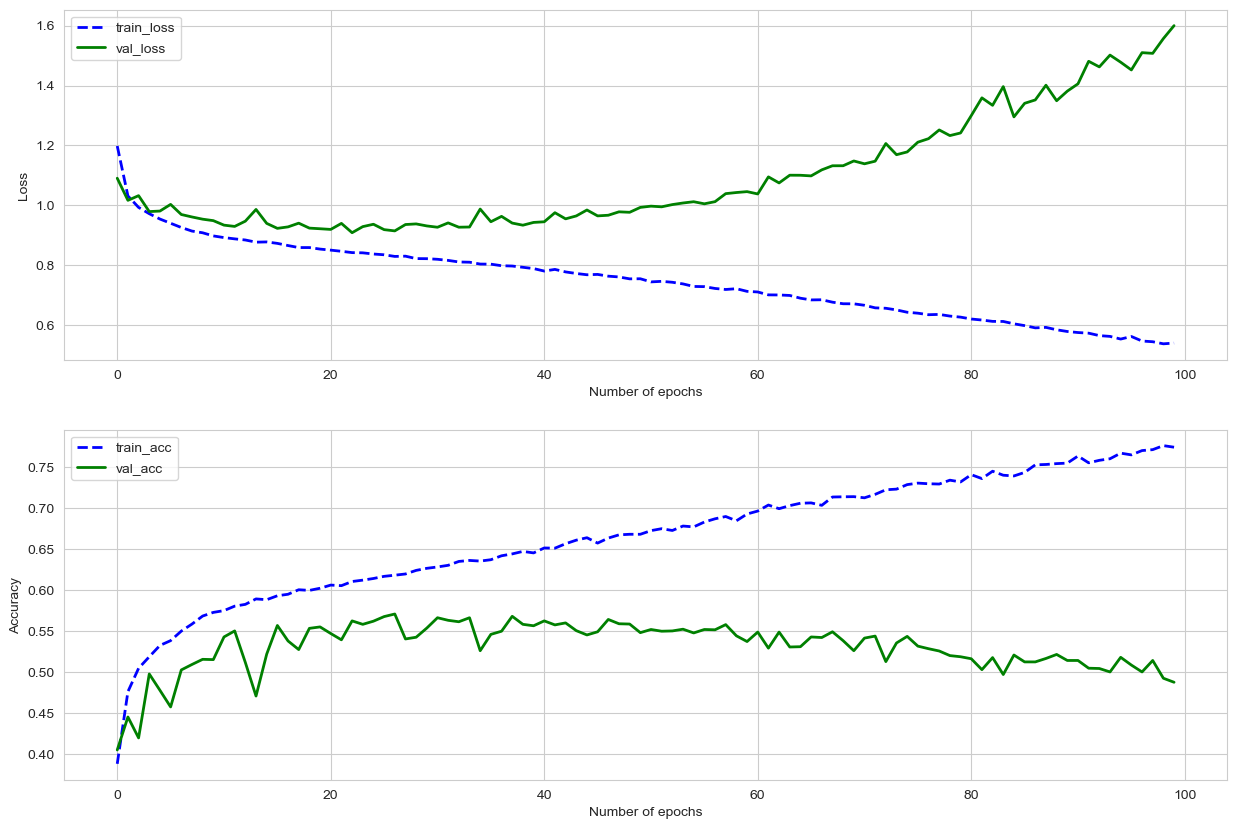

In [287]:
plt.figure(figsize=(15,10))
plt.subplot(2,1,1)
plt.plot(history.history['loss'],'b--',lw=2,label='train_loss')
plt.plot(history.history['val_loss'],'g-',lw=2,label='val_loss')
plt.legend()
# plt.ylim([.5,1.3])
plt.xlabel('Number of epochs')
plt.ylabel('Loss')
plt.subplot(2,1,2)
plt.plot(history.history['accuracy'],'b--',lw=2,label='train_acc')
plt.plot(history.history['val_accuracy'],'g-',lw=2,label='val_acc')
plt.legend()
# plt.ylim([.2,1.0])
plt.xlabel('Number of epochs')
plt.ylabel('Accuracy')
plt.show()

In [288]:
target_names = [mapping[str(i)] for i in range(3)]
y_pred = model_mid.predict(X_test)
y_pred_bool = np.argmax(y_pred, axis=1)
y_test_bool = np.argmax(y_test, axis=1)
print(classification_report(y_pred_bool, y_test_bool, target_names=target_names))
print(confusion_matrix(y_test_bool, y_pred_bool, labels=[0,1,2]))

112/112 [==============================] - 0s 4ms/step
              precision    recall  f1-score   support

        down       0.67      0.64      0.66      1766
  stationary       0.39      0.35      0.37       596
          up       0.55      0.61      0.57      1211

    accuracy                           0.58      3573
   macro avg       0.54      0.53      0.53      3573
weighted avg       0.58      0.58      0.58      3573

[[1136  217  344]
 [ 190  208  132]
 [ 440  171  735]]


In [289]:
print("Accuracy is {}%".format(accuracy*100))

Accuracy is 58.186399936676025%


In [507]:
model_mid.save('./models/model_mid')

INFO:tensorflow:Assets written to: ./models/model_mid/assets


INFO:tensorflow:Assets written to: ./models/model_mid/assets


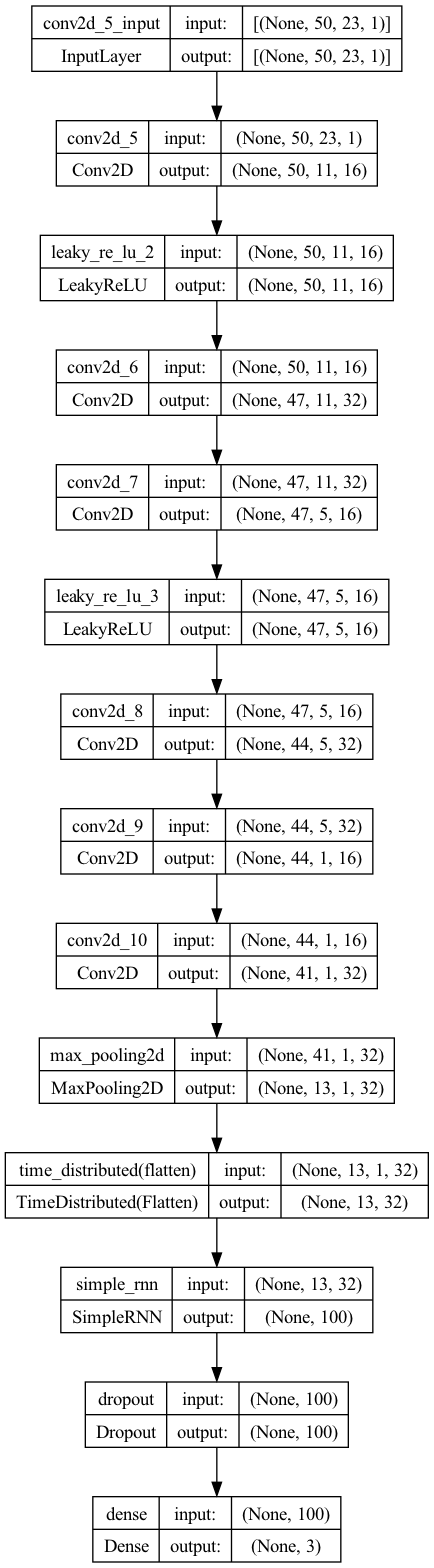

In [19]:
from keras.utils.vis_utils import plot_model #need to install graphviz and pydot for it to work
from IPython.display import Image
plot_model(model_mid, to_file='./Images_model/Kclassification_model_ConvRnn.png', show_shapes=True, show_layer_names=True)

Image(filename='./Images_model/Kclassification_model_ConvRnn.png')

### ConvLSTM Model

In [20]:
model = Sequential()
model.add(Conv2D(filters=16, kernel_size=(1,2), input_shape=(Timestep,23,1), strides=(1, 2)))
model.add(LeakyReLU(alpha=0.01))
model.add(Conv2D(filters=16, kernel_size=(4,1)))
model.add(Conv2D(filters=16, kernel_size=(4,1)))
model.add(Conv2D(filters=16, kernel_size=(1,2), strides=(1, 2)))
model.add(LeakyReLU(alpha=0.01))
model.add(Conv2D(filters=16, kernel_size=(4,1)))
model.add(Conv2D(filters=16, kernel_size=(4,1)))
model.add(Conv2D(filters=16, kernel_size=(1,5), input_shape=(100,10,1)))
model.add(Conv2D(filters=32, kernel_size=(4,1)))
model.add(Conv2D(filters=32, kernel_size=(4,1)))
model.add(MaxPooling2D(pool_size=(3,1)))
model.add(TimeDistributed(Flatten()))

# lstm layer
model.add(LSTM(100))
model.add(Dense(3,activation='softmax'))
# compile model and summarize
adam = Adam(lr=LEARNING_RATE, epsilon=1)
model.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_11 (Conv2D)          (None, 50, 11, 16)        48        
                                                                 
 leaky_re_lu_4 (LeakyReLU)   (None, 50, 11, 16)        0         
                                                                 
 conv2d_12 (Conv2D)          (None, 47, 11, 16)        1040      
                                                                 
 conv2d_13 (Conv2D)          (None, 44, 11, 16)        1040      
                                                                 
 conv2d_14 (Conv2D)          (None, 44, 5, 16)         528       
                                                                 
 leaky_re_lu_5 (LeakyReLU)   (None, 44, 5, 16)         0         
                                                                 
 conv2d_15 (Conv2D)          (None, 41, 5, 16)        

/Users/yujiewang/anaconda3/lib/python3.9/site-packages/keras/optimizers/optimizer_v2/adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [488]:
history=model.fit(X_train,y_train, epochs=EPOCHS,validation_data=(X_val, y_val), batch_size=BATCH_SIZE)

Epoch 1/100
115/115 [==============================] - 4s 27ms/step - loss: 1.0991 - accuracy: 0.3272 - val_loss: 1.0896 - val_accuracy: 0.5329
Epoch 2/100
115/115 [==============================] - 3s 26ms/step - loss: 1.0951 - accuracy: 0.3649 - val_loss: 1.0913 - val_accuracy: 0.5385
Epoch 3/100
115/115 [==============================] - 3s 26ms/step - loss: 1.0928 - accuracy: 0.3702 - val_loss: 1.0945 - val_accuracy: 0.5353
Epoch 4/100
115/115 [==============================] - 3s 25ms/step - loss: 1.0910 - accuracy: 0.3706 - val_loss: 1.0960 - val_accuracy: 0.5091
Epoch 5/100
115/115 [==============================] - 3s 25ms/step - loss: 1.0882 - accuracy: 0.3796 - val_loss: 1.0955 - val_accuracy: 0.4640
Epoch 6/100
115/115 [==============================] - 3s 26ms/step - loss: 1.0827 - accuracy: 0.4079 - val_loss: 1.1019 - val_accuracy: 0.3380
Epoch 7/100
115/115 [==============================] - 3s 25ms/step - loss: 1.0719 - accuracy: 0.4240 - val_loss: 1.1181 - val_accuracy:

In [489]:
score, accuracy = model.evaluate(X_test, y_test, batch_size=BATCH_SIZE)
print("Accuracy is {}%".format(accuracy*100))

36/36 [==============================] - 0s 9ms/step - loss: 0.8350 - accuracy: 0.6208
Accuracy is 62.076687812805176%


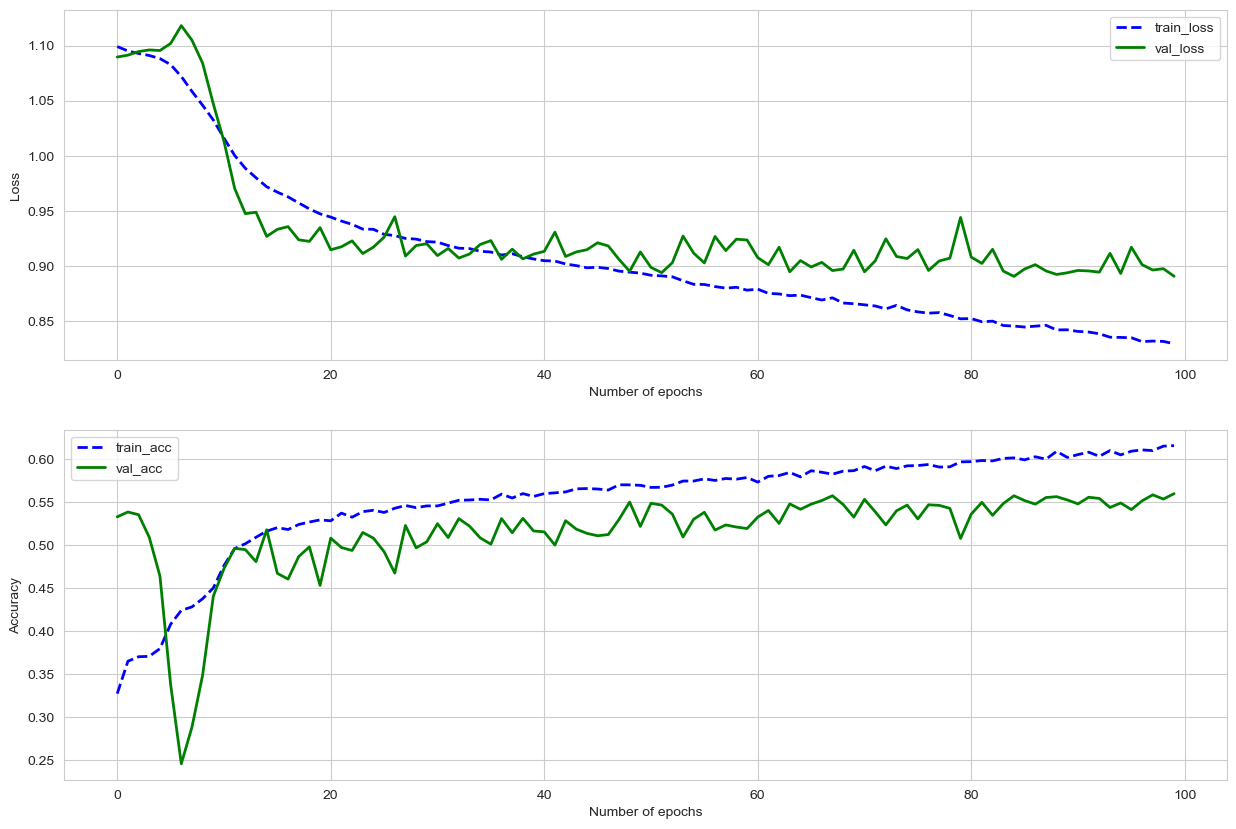

In [490]:
plt.figure(figsize=(15,10))
plt.subplot(2,1,1)
plt.plot(history.history['loss'],'b--',lw=2,label='train_loss')
plt.plot(history.history['val_loss'],'g-',lw=2,label='val_loss')
plt.legend()
# plt.ylim([.5,1.3])
plt.xlabel('Number of epochs')
plt.ylabel('Loss')
plt.subplot(2,1,2)
plt.plot(history.history['accuracy'],'b--',lw=2,label='train_acc')
plt.plot(history.history['val_accuracy'],'g-',lw=2,label='val_acc')
plt.legend()
# plt.ylim([.2,1.0])
plt.xlabel('Number of epochs')
plt.ylabel('Accuracy')
plt.show()

In [491]:
target_names = [mapping[str(i)] for i in range(3)]
y_pred = model.predict(X_test)
y_pred_bool = np.argmax(y_pred, axis=1)
y_test_bool = np.argmax(y_test, axis=1)
print(classification_report(y_pred_bool, y_test_bool, target_names=target_names))
print(confusion_matrix(y_test_bool, y_pred_bool, labels=[0,1,2]))

112/112 [==============================] - 1s 4ms/step
              precision    recall  f1-score   support

        down       0.76      0.68      0.72      1972
  stationary       0.40      0.32      0.35       623
          up       0.52      0.69      0.59       978

    accuracy                           0.62      3573
   macro avg       0.56      0.56      0.55      3573
weighted avg       0.63      0.62      0.62      3573

[[1345  215  210]
 [ 208  197   92]
 [ 419  211  676]]


In [492]:
print("Accuracy is {}%".format(accuracy*100))

Accuracy is 62.076687812805176%


In [506]:
model.save('./models/Kclassifcation_ConvLSTM')

INFO:tensorflow:Assets written to: ./models/Kclassifcation_ConvLSTM/assets


INFO:tensorflow:Assets written to: ./models/Kclassifcation_ConvLSTM/assets


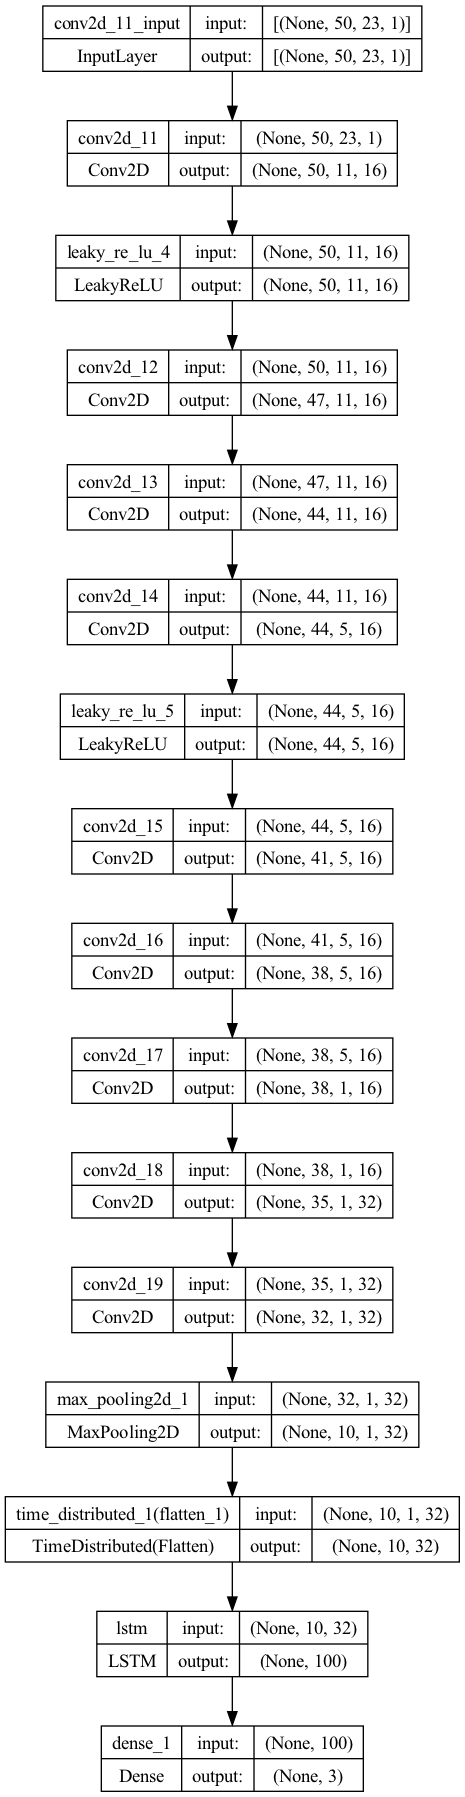

In [21]:
from keras.utils.vis_utils import plot_model #need to install graphviz and pydot for it to work
from IPython.display import Image
plot_model(model, to_file='./Images_model/Kclassification_model_Convlstm.png', show_shapes=True, show_layer_names=True)

Image(filename='./Images_model/Kclassification_model_Convlstm.png')

### LSTM Model

In [23]:
from tensorflow.keras import regularizers

In [24]:
model1 = Sequential()
model1.add(Conv2D(filters=16, kernel_size=(1,2), input_shape=(Timestep,23,1), strides=(1, 2)))
model1.add(LeakyReLU(alpha=0.01))
model1.add(Conv2D(filters=16, kernel_size=(1,1)))
model1.add(Conv2D(filters=16, kernel_size=(1,1)))

model1.add(Conv2D(filters=16, kernel_size=(1,2), strides=(1, 2)))
model1.add(LeakyReLU(alpha=0.01))
model1.add(Conv2D(filters=16, kernel_size=(1,1)))
model1.add(Conv2D(filters=16, kernel_size=(1,1)))

model1.add(Conv2D(filters=16, kernel_size=(1,4), input_shape=(100,10,1)))
model1.add(LeakyReLU(alpha=0.01))
model1.add(Conv2D(filters=16, kernel_size=(1,1)))
model1.add(Conv2D(filters=16, kernel_size=(1,1)))

model1.add(MaxPooling2D(pool_size=(1,1)))
model1.add(TimeDistributed(Flatten()))

# lstm layer
model1.add(LSTM(100,kernel_regularizer=regularizers.l2(0.01),return_sequences=False))
model1.add(Dropout(0.30))
model1.add(Dense(3,activation='softmax'))

# compile model and summarize
adam = Adam(lr=LEARNING_RATE, epsilon=EPSILON)
model1.compile(optimizer=adam, loss='binary_crossentropy', metrics=['accuracy'])
model1.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_29 (Conv2D)          (None, 50, 11, 16)        48        
                                                                 
 leaky_re_lu_9 (LeakyReLU)   (None, 50, 11, 16)        0         
                                                                 
 conv2d_30 (Conv2D)          (None, 50, 11, 16)        272       
                                                                 
 conv2d_31 (Conv2D)          (None, 50, 11, 16)        272       
                                                                 
 conv2d_32 (Conv2D)          (None, 50, 5, 16)         528       
                                                                 
 leaky_re_lu_10 (LeakyReLU)  (None, 50, 5, 16)         0         
                                                                 
 conv2d_33 (Conv2D)          (None, 50, 5, 16)        

/Users/yujiewang/anaconda3/lib/python3.9/site-packages/keras/optimizers/optimizer_v2/adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [494]:
history=model1.fit(X_train,y_train, epochs=EPOCHS,validation_data=(X_val, y_val), batch_size=BATCH_SIZE)

Epoch 1/100
115/115 [==============================] - 8s 60ms/step - loss: 1.2872 - accuracy: 0.3483 - val_loss: 1.2732 - val_accuracy: 0.5318
Epoch 2/100
115/115 [==============================] - 7s 62ms/step - loss: 1.2643 - accuracy: 0.3636 - val_loss: 1.2478 - val_accuracy: 0.5451
Epoch 3/100
115/115 [==============================] - 7s 61ms/step - loss: 1.2394 - accuracy: 0.3637 - val_loss: 1.2216 - val_accuracy: 0.5441
Epoch 4/100
115/115 [==============================] - 7s 61ms/step - loss: 1.2148 - accuracy: 0.3655 - val_loss: 1.1960 - val_accuracy: 0.5437
Epoch 5/100
115/115 [==============================] - 7s 62ms/step - loss: 1.1909 - accuracy: 0.3651 - val_loss: 1.1719 - val_accuracy: 0.5437
Epoch 6/100
115/115 [==============================] - 7s 62ms/step - loss: 1.1682 - accuracy: 0.3653 - val_loss: 1.1498 - val_accuracy: 0.5437
Epoch 7/100
115/115 [==============================] - 7s 62ms/step - loss: 1.1473 - accuracy: 0.3662 - val_loss: 1.1301 - val_accuracy:

In [495]:
score, accuracy = model1.evaluate(X_test, y_test, batch_size=BATCH_SIZE)
print("Accuracy is {}%".format(accuracy*100))

36/36 [==============================] - 1s 19ms/step - loss: 0.5554 - accuracy: 0.5250
Accuracy is 52.504897117614746%


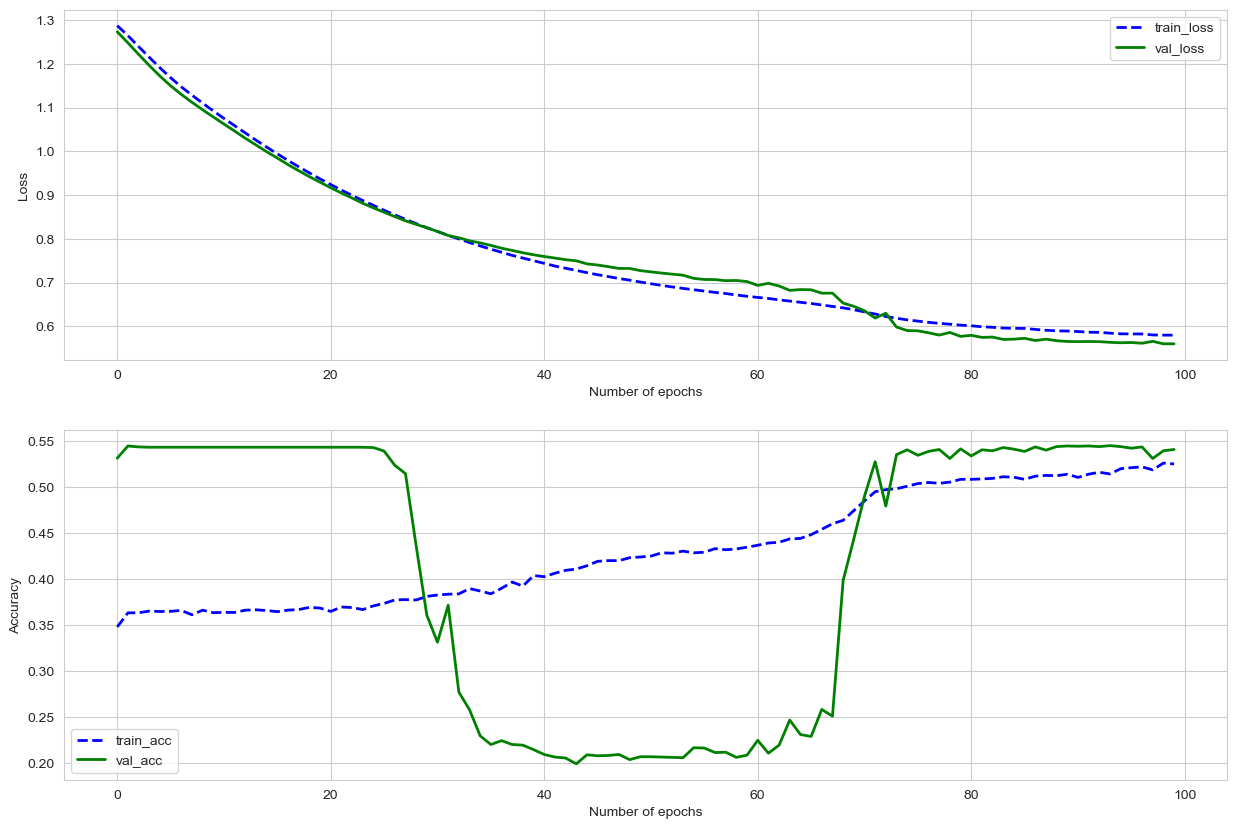

In [496]:
plt.figure(figsize=(15,10))
plt.subplot(2,1,1)
plt.plot(history.history['loss'],'b--',lw=2,label='train_loss')
plt.plot(history.history['val_loss'],'g-',lw=2,label='val_loss')
plt.legend()
# plt.ylim([.5,1.3])
plt.xlabel('Number of epochs')
plt.ylabel('Loss')
plt.subplot(2,1,2)
plt.plot(history.history['accuracy'],'b--',lw=2,label='train_acc')
plt.plot(history.history['val_accuracy'],'g-',lw=2,label='val_acc')
plt.legend()
# plt.ylim([.2,1.0])
plt.xlabel('Number of epochs')
plt.ylabel('Accuracy')
plt.show()

In [497]:
target_names = [mapping[str(i)] for i in range(3)]
y_pred = model1.predict(X_test)
y_pred_bool = np.argmax(y_pred, axis=1)
y_test_bool = np.argmax(y_test, axis=1)
print(classification_report(y_pred_bool, y_test_bool, target_names=target_names))
print(confusion_matrix(y_test_bool, y_pred_bool, labels=[0,1,2]))

112/112 [==============================] - 1s 9ms/step
              precision    recall  f1-score   support

        down       0.82      0.57      0.67      2546
  stationary       0.52      0.35      0.42       728
          up       0.13      0.57      0.21       299

    accuracy                           0.53      3573
   macro avg       0.49      0.50      0.43      3573
weighted avg       0.70      0.53      0.58      3573

[[1449  234   87]
 [ 196  258   43]
 [ 901  236  169]]


In [505]:
model1.save('./models/Kclassification_model_lstm')

INFO:tensorflow:Assets written to: ./models/Kclassification_model_lstm/assets


INFO:tensorflow:Assets written to: ./models/Kclassification_model_lstm/assets


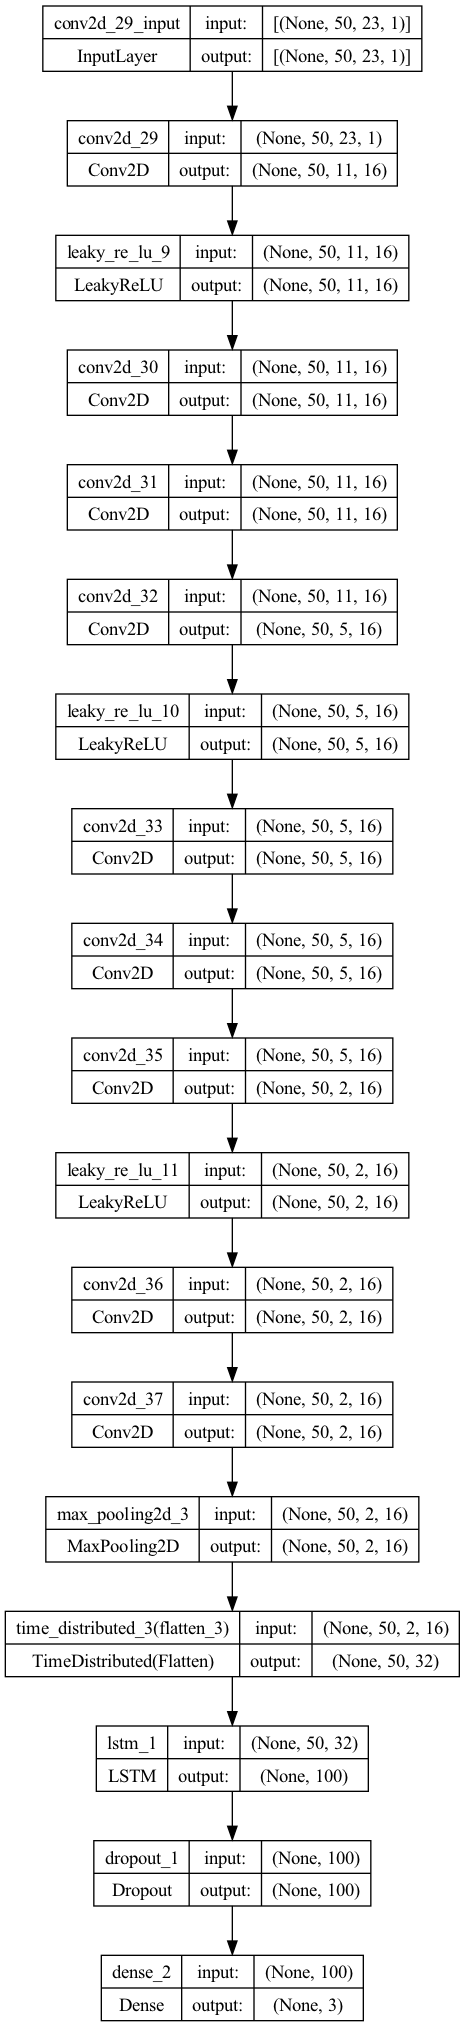

In [25]:
from keras.utils.vis_utils import plot_model #need to install graphviz and pydot for it to work
from IPython.display import Image
plot_model(model1, to_file='./Images_model/Kclassification_model1_lstm.png', show_shapes=True, show_layer_names=True)

Image(filename='./Images_model/Kclassification_model1_lstm.png')